## HW \#2 Solutions


### 1. Not so fast!   

Use a perturbation analysis to show that the leapfrog scheme (time-centered difference): 

$\rho_j^{n+1} -\rho_j^{n-1} = -v_o \frac{\Delta t}{\Delta x} (\rho_{j+1}^n - \rho_{j-1}^n)$,

is conditionally stable, i.e. it is stable as long as $\Delta t \le \Delta x /v_0$. Assume that $v_0$ is a constant velocity.


To check stability, we will perturb it will a wave of the form: $\rho_j^n(k) = \xi_k^n e^{ikj \Delta x}$. This gives:

$\rho_j^{n+1} -\rho_j^{n-1} = -v_o \frac{\Delta t}{\Delta x} (\rho_{j+1}^n - \rho_{j-1}^n)$

$\xi_j^{n+1}  e^{ikj \Delta x} - \xi_j^{n-1}  e^{ikj \Delta x} = -v_o \frac{\Delta t}{\Delta x} (\xi_j^n e^{ik\Delta x (j+1)} - \xi_j^n e^{-ik\Delta x (j-1)} ) $

$\xi - \xi^{-1 } = -v_o \frac{\Delta t}{\Delta x} (e^{ik\Delta x} -  e^{-ik\Delta x} )$

$\xi - \xi^{-1 } = -v_o \frac{\Delta t}{\Delta x}[ 2 i~ sin(k \Delta x)] $

$\xi^2 + v_o \frac{2i\Delta t}{\Delta x} sin(k \Delta x) \xi -1 = 0 $

This is a quadratic equation with the roots:
    
$\xi =  \frac{v_o \frac{2i\Delta t}{\Delta x}sin(k \Delta x)   \pm \sqrt{ -v_o^2 \frac{4\Delta t^2}{\Delta x^2} sin^2(k \Delta x) +4}}{2} $

$\xi =  v_o \frac{i\Delta t}{\Delta x}sin(k \Delta x)   \pm \sqrt{1 -v_o^2 \frac{\Delta t^2}{\Delta x^2} sin^2(k \Delta x)} $

The solution will be stable as long as $||\xi || \le 1$. This is true whenever $v_o \frac{\Delta t}{\Delta x}|sin(k \Delta x)| \le1$. Since $|sin x| \le 1$ always, we must have $\Delta t \le \Delta x / v_o$.


### 2. Sod it! 

Using the finite volume discretization given in class and a programming language of your choice, write your own 1D hydrodynamic solver. 


(a)  The quintessential shock benchmark problem is the Sod Shock Tube (first formulated by Sod in 1978). 
The problem involves setting up two discontinuous states at $t=0$: a hot dense gas on the left and a cool, low-density gas on the right. The result is a shock wave that travels left to right into the cold gas, and a rarefaction wave that travels into the dense gas on the left. 
 
 Setup: Let the domain be $[0,2]$, and set $\rho_1 = 1.0$, $p_1 = 1.0$ for $x \leq 0.75$ and $\rho_2 =0.125$, $p_2 = 0.1$ for $x>0.75$. Assume $\gamma = 1.4$ and use this to determine the specific energy. Set $v=0$ everywhere initially. Use symmetry boundary conditions and $N=200$ grid cells. Set the time step according to a CFL number of 0.5. implement an artificial viscosity with coefficients $q_0=4$ and $q_1 = 0.5$.}
 
 Compute the solution at $t=0.245$ and make plots of the density, velocity, pressure and specific energy as a function of position.  Compare the shock properties (speed, density jump, pressure jump, velocity) with that predicted for these conditions (e.g. see Stone \& Norman 1992).


In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Function to calculate timestep using CFL condition
def timestep(x_vals, cs_vals, v_vals, cfl):
    """
    x_vals  array of cell edge positions
    cs_vals array of sound speed values, defined at the cell centers 
    v_vals  array of velocities defined at cell edges
    cfl     courant number (should be less than 1)
    """
    dxvals = np.array([x_vals[i+1] - x_vals[i] for i in range(0, len(x_vals) - 1, 1)])
    # Note dx is not constant, so can't just do dx/max(v)
    dt = cfl * np.min(dxvals/(cs_vals + np.abs(v_vals[:-1])))
    return dt

# Function to run Sod Shock Tube
def shocktube(N, tf, cfl, xmin, xmax, xc, gamma, rho1, rho2, p1, p2, q0, q1):
    """
    N       Number of cells
    tf      Final time in the calculation
    xmin    Leftmost cell edge position
    xmin    Rightmost cell edge position
    xc      Location of center discontinuity
    gamma   EOS adiabatic index -- must be > 0
    rho1    Left-side density
    rho2    Right-side density
    p1      Left-side pressure
    p2      Right-side pressure
    q0, q1  Viscosity coefficient
    """
    dx = (xmax - xmin) / N
    vi = 0. # Initial Velocity
    
    # Set the edge-defined "old" values
    # Note that the edge arraus should have one more point than the number of cells
    x_vals = np.linspace(xmin,xmax,N + 1)
    v_vals = np.array([ vi for i in x_vals ])

    # Set the cell-centered "old" values
    ctr_vals = np.linspace(xmin + dx/2. ,xmax - dx/2.,N)
    rho_vals = np.array([ rho1 if i < xc else rho2 for i in ctr_vals ])

    # Define two separate mass increments
    dmj_half = (xmax-xmin)*rho_vals / N
    dmj = np.array([dmj_half[i+1] if i == -1 else
                dmj_half[len(dmj_half)-1] if i ==len(dmj_half) - 1 else
                (dmj_half[i] + dmj_half[i+1])/2. for i in range(-1, len(dmj_half), 1) ])

    p_vals = np.array([ p1 if i < xc else p2 for i in ctr_vals ])
    e_vals = p_vals * (gamma - 1)**-1 * rho_vals**-1
    cs_vals = ( gamma * p_vals / rho_vals )**0.5
    q_vals = np.array([0 for i in rho_vals])
    
    # START THE LOOP HERE 
    t=0
    dtold = timestep(x_vals, cs_vals, v_vals, cfl)
    while t < tf: 
        # RATHER than use ghost cells, we define some "delta" arrays
        # These compute the differences
        # e.g. dp_j+1/2  -  dp_j-1/2
        # In calculating these differences, we account for the endpoints with an if condition
        # So the boundary conditions are still imposed
        # Use symmetric boundary conditions
        # EVEN:
        dp_vals = np.array([ 0 if (i==-1 or i==len(p_vals) -1) else
                            p_vals[i+1] - p_vals[i] for i in range(-1, len(p_vals), 1) ])
        dq_vals = np.array([ 0 if (i==-1 or i==len(q_vals) -1) else
                            q_vals[i+1] - q_vals[i] for i in range(-1, len(q_vals), 1) ])
        
        # Now we update:
        dtnew = timestep(x_vals, cs_vals, v_vals, cfl)
        dthalf = (dtnew+dtold)/2.0
        v_vals_new = v_vals - dtnew/dmj * (dp_vals + dq_vals)

        x_vals_new = x_vals + dthalf * v_vals_new
        dx_vals_new = np.array([ x_vals_new[i + 1] - x_vals_new[i] for i in range(0, len(x_vals_new) - 1, 1)])
        rho_vals_new = dmj_half / dx_vals_new

        # Now we step forward q:
        cs_vals_new = ( gamma * p_vals / rho_vals_new )**0.5
        rho_bar = 0.5 * ( (rho_vals_new)**-1  +  (rho_vals)**-1 )
        dv_vals_new = np.array([ v_vals_new[i + 1] - v_vals_new[i] 
                                for i in range(0, len(v_vals_new) - 1, 1)])
        param = (dv_vals_new / dx_vals_new)
        
        q_vals_new = [ (q0 * (dv_vals_new[i])**2 - q1 * (dv_vals_new[i])) 
                      * cs_vals_new[i] * rho_bar[i]**-1 
                      if param[i] < 0 else 0 for i in range(len(dv_vals_new))   ]
        
        # Note we use the old artificial viscosity here.
        e_vals_new = e_vals - (p_vals + q_vals) * ((rho_vals_new)**-1 - (rho_vals)**-1)
        p_vals_new = e_vals_new * rho_vals_new * (gamma - 1)
                      
        # Now we replace the "old" variable lists with their "new" counterparts.
        x_vals = x_vals_new
        v_vals = v_vals_new
        rho_vals = rho_vals_new
        p_vals = p_vals_new
        e_vals = e_vals_new
        cs_vals = cs_vals_new
        q_vals = q_vals_new
        dtold = dtnew
        t = t + dtnew

    return x_vals, rho_vals, v_vals, p_vals, e_vals 

# Function to make plots
def plot_shock(x_vals, rho_vals, v_vals, p_vals, e_vals, t):
    """
    x_vals   array of cell edge positions 
    rho_vals array of densities 
    v_vals   array of velocities 
    e_vals   array of internal energies 
    t        time of the solution
    """
    
    xmin = np.min(x_vals)
    xmax = np.max(x_vals)
    x_plot = np.array([ 0.5 * (x_vals[i + 1] + x_vals[i]) for i in range(0, len(x_vals) - 1, 1)])

    fig, axs = plt.subplots(2, 2)

    axs[0,0].set_title('Density vs. Position')
    axs[0, 0].plot(x_plot, rho_vals,label = 't= %1.3f' %t)
    axs[0, 0].set(xlabel = 'x', ylabel = r'$\rho$')
    axs[0, 0].legend(loc='upper right')
    axs[0, 0].axis([xmin,xmax,-0.1,1.1])

    axs[1,0].set_title('Velocity vs. Position')
    axs[1, 0].plot(x_vals, v_vals)
    axs[1, 0].set(xlabel = 'x', ylabel = 'v')
    axs[1, 0].axis([xmin,xmax,-0.1,1.1])
              
    axs[1,1].set_title('Pressure vs. Position')
    axs[1, 1].plot(x_plot, p_vals)
    axs[1, 1].set(xlabel = 'x', ylabel='P')
    axs[1, 1].axis([xmin,xmax,-0.1,1.1])   

    axs[0,1].set_title('Specific Energy vs. Position')
    axs[0, 1].plot(x_plot, e_vals)
    axs[0, 1].set(xlabel = 'x', ylabel = 'e')
    axs[0, 1].axis([xmin,xmax,0,4]) 

    fig.tight_layout()
    plt.show()  

/Users/so8266/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/so8266/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


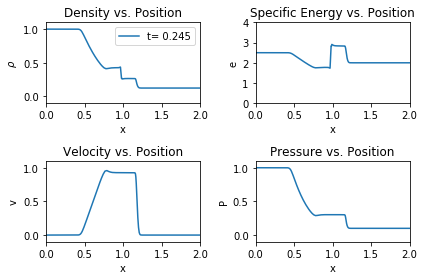

In [3]:
# Initialize and Run Shocktube

#Set up the initial Conditions
Npoints = 200. # Grid points
tfinal = 0.245 # Final time
cfl = 0.5      # Fiducial CFL number

gamma = 1.4
xleft = 0.
xright = 2. 
xcenter = 0.75 # Position of discontinuity

# x <= xc :
rholeft = 1.0
pleft = 1.0

# x > xc :
rhoright = 0.125
pright = 0.1

q0 = 4.0  # Viscosity Coefficients
q1 = 0.5  # Fiducial: 4.0, 0.5

# Run shock tube
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)

# Plot
plot_shock(x, rho, v, p, e, tfinal)
    

Inspection of Stone & Norman Figure 11, which was generated with the same initial conditions,  shows the salient features of the shock solution. You can use WebPlotDigitizer (https://automeris.io/WebPlotDigitizer/)  to pull out the solution for comparison. Or you can solve for the main features using the shock jump conditions. 

We can use the shock jump conditions to get the initial Mach number, and hence velocity, of the shock. Given $\gamma = 1.4$ and $P_2/P_1 = 10$

$\frac{P_2}{P_1} = \frac{2\gamma \mathcal{M}^2 - (\gamma -1)}{\gamma +1} \rightarrow \frac{2 \gamma \mathcal{M}^2}{\gamma+1}$

$10 = \frac{2.8 \mathcal{M}^2 - 0.4}{2.4} \rightarrow \mathcal{M} = 2.95$

This is very close to what you get if you make the strong shock approximation ($\mathcal{M} = 2.93$). We can check that this is the case by looking at the nonzero velocities in the first few time steps. However, the shock does not propagate at this velocity for long, but instead gradually slows, since a rarefaction wave simultaneously moves backwards into the dense gas, lowering the density and pressure behind the shock. This rarefaction waves propagates at the speed of sound.  The sound speed in the dense gas is $(\gamma P_1/\rho_1)^{1/2} = 1.2$, so it will have traveled $0.29$ into the dense gas from the starting point. This agrees with the computational solution.

Meanwhile, the velocity and position of the shock can be related to the solution of the rarefaction wave and must be solved iteratively. Across the contact discontinuity the velocity is always the same as the post-shock velocity. Iterating the solution or comparing with one of the code benchmarking papers (such as Stone \& Norman 1992 or Hawley et al. 1984) we find the post-shock velocity we expect is  $v\simeq 0.9$, $e\simeq2.85$, $p \simeq 2.8$, and $\rho \simeq 2.7 $. The shock location should be $x \simeq x_c + 0.42 $.

(b) Simple numerical schemes are prone to certain artifacts near the shock interface. What deviations from the analytic solution do you notice?   What numerical improvements would you apply to address them?

There are several deviations from the strictly correct solution. The most obvious is the impact of the artificial viscosity, which smears out the shock over several zones. Hydrodynamic shocks are also prone to "over-shoots", in which the solution exceeds the expected value. This is visible in the velocity at the beginning of the rarefaction wave and in the density and specific energy plots at the location of the initial contact discontinuity.
 
 These issues can be addressed by using a higher order (e.g., second order like the Zeus code) scheme. A better implementation of artificial viscocity could also be helpful in reducing the smearing of the shock over so many grid cells, but some smearing is unavoidable.

Check the shock solution for $N=100, 200$ and 400 grid cells. How quickly is the solution converging? Is this consistent with your expectations?

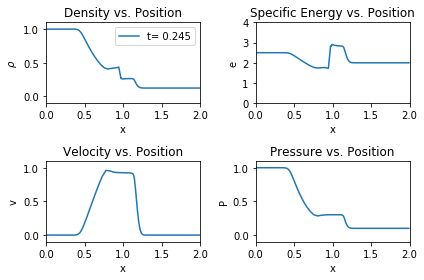

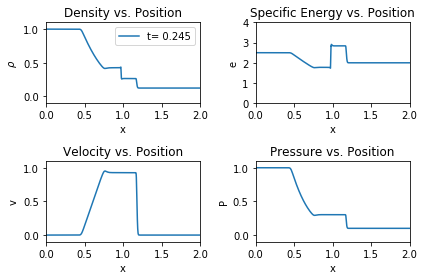

In [4]:
Npoints = 100
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

Npoints = 400
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

 As the resolution increases by a factor of two the discontinuities become a factor of two sharper. When the resolution decreases by a factor of two, the discontinuities are smeared out by a factor of two more. This is as we expect; the shock will always be smeared out by a few cells at the given resolution. Meanwhile, the overshoots and other artifacts become slightly smaller at higher resolution. The accurately of the solution changes linearly with resolution, implying it is a first order scheme, as we expect.


2c. Decrease the CFL number to 0.25 and increase it to 1.1. What happens to the shock solution in each case? 

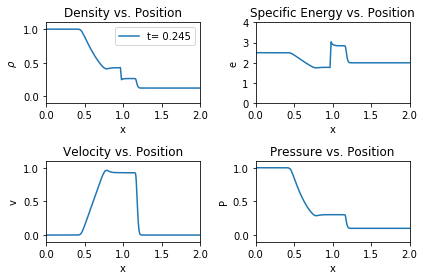

/Users/so8266/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


ValueError: Axis limits cannot be NaN or Inf

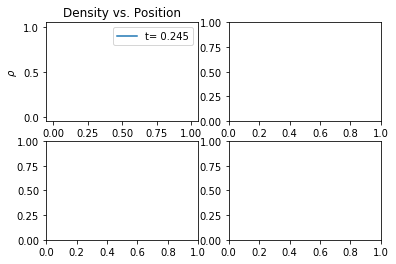

In [5]:
Npoints = 200
cfl = 0.25
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

cfl = 1.1
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

There is little obvious impact from decreasing the CFL number. Note that the scheme should be 1st order accurate in time, so it should get a factor of 2 more accurate when dt becomes two times smaller, but the change is not readily apparent from the plot. 

For CFL values above one, the solution begins to becomes. If the CFL is increased sufficiently the solution begins to develop oscillations. The code crashes pretty quickly after that....

(e) Evaluate how sensitive the solution is to magnitude of the coefficient of artificial viscosity. Increase the viscosity coefficients by a factor of 2 and decrease them by a factor of 2. How does the solution change? What impact do the two different viscous components have on the solution?}

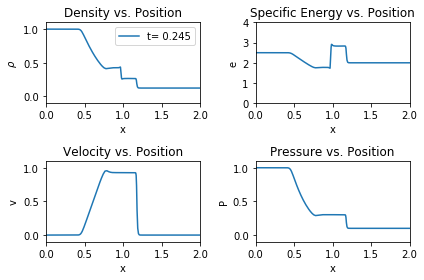

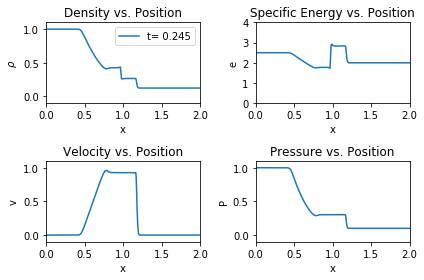

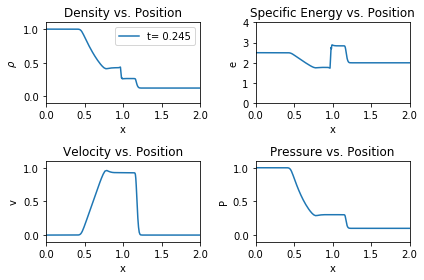

/Users/so8266/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


ValueError: Axis limits cannot be NaN or Inf

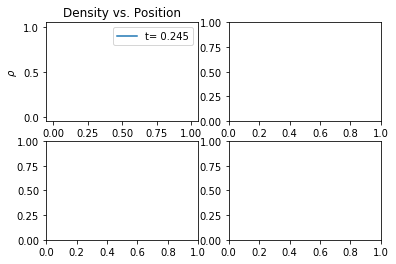

In [6]:
Npoints = 200
cfl = 0.5
q0 = 0.4
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

q0 = 4.0/2.0  # Viscosity Coefficients
q1 = 0.5/2.0  # Fiducial: 4.0, 0.5
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

#q0 = 4.0*2.0  # Viscosity Coefficients
#q1 = 0.5*2.0  # Fiducial: 4.0, 0.5
#x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
#plot_shock(x, rho, v, p, e, tfinal)

q0 = 4.0*1.1  # Viscosity Coefficients
q1 = 0.5*1.1  # Fiducial: 4.0, 0.5
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)

q0 = 4.0*2.0  # Viscosity Coefficients
q1 = 0.5*2.0  # Fiducial: 4.0, 0.5
x, rho, v, p, e = shocktube(Npoints, tfinal, cfl, xleft, xright, xcenter, gamma, rholeft, rhoright, pleft, pright, q0, q1)
plot_shock(x, rho, v, p, e, tfinal)



The solution is very sensitive to the artificial viscosity.  For smaller values, the shock is sharper, but the magnitude of the numerical artifacts increases. If the viscosity is removed completely the solution is prone to significant oscillations on the shock front.

For large values the shock begins to smear out, but increasing by a factor of 2 makes the solution completely unstable. This is because the viscosity begins to dominate the internal energy. It seems we can at most increase it by 10%.